# Unsupervised Learning & Hyperparameter Tuning


## Introduction

For this project, our goal is to automate LendingClub's lending decisions.
Using the lending data stored in https://storage.googleapis
.com/335-lending-club/lending-club.zip, we are going to tackle this challenge
 in a three-step plan. The first step is to create a machine learning model
 to classify loans into accepted/rejected, which is the goal of this notebook.
 The second step is to predict the grade for the loan, and the third step is
 to predict the subgrade and the interest rate. For subsequent steps, see
 notebooks grade.ipynb, subgrade.ipynb and interest.ipynb, respectively.

## Accepted vs Rejected Loans

## Exploratory Data Analysis

First of all, let us import the necessary libraries and packages:

In [2]:
import sqlite3

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from pycaret.classification import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, auc, \
    f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, \
    cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from script import make_mi_scores, plot_mi_scores, perform_ztest, \
    perform_anova, downgrade_column_types

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In order to work with the data provided more efficiently, a SQL database has
been created. This database has two columns, accepted and rejected, and two
views, accepted_relevant and common_columns. For this part, we are going to
use view common_columns, which contains the information common to all loans
so we can build a classification model.

In [3]:
conn = sqlite3.connect('rejected_2007_to_2018Q4.db')
cursor = conn.cursor()

In [4]:
df = pd.read_sql_query("SELECT * FROM common_columns", conn)

We are going to handle some data types and missing values. Similarly, because
 we are dealing with big volumes of data, we are going to try to minimise memory
usage as much as possible.

In [5]:
df['Loan_Amount'] = df['Loan_Amount'].replace('', 0).astype(float)
df['Debt_To_Income_Ratio'] = df['Debt_To_Income_Ratio'].astype(float)

In [6]:
df = downgrade_column_types(df)

In [7]:
df.memory_usage(deep=True).sum()

188279099

Now that we have adjusted data types, let us take a closer look at the data
we are working with.

In [24]:
df.shape

(5641542, 8)

In [66]:
df.dtypes

Loan_Amount              float64
Loan_Title              category
Debt_To_Income_Ratio     float64
Zip_Code                category
State                   category
Risk_Score               float32
Employment_Length           Int8
Status                      Int8
dtype: object

As we can see, we have over 5 million rows and 8 columns. 5 of them are
numerical, while the other three are categorical.

Let's use describe, as well as some plots, to gather more information about our data.

In [29]:
df.describe()

,Loan_Amount,Debt_To_Income_Ratio,Risk_Score,Employment_Length,Status
count,5.641542e+06,5.641542e+06,3.420522e+06,5356599.0,5641542.0
mean,1.367463e+04,1.820696e+02,6.706339e+02,3.086273,0.400676
std,1.141277e+04,2.202114e+04,9.484332e+01,3.777319,0.490036
min,0.000000e+00,-1.000000e+00,0.000000e+00,0.0,0.0
25%,5.000000e+03,6.540000e+00,6.620000e+02,0.0,0.0
50%,1.000000e+04,1.225500e+01,6.820000e+02,1.0,0.0
75%,2.000000e+04,2.433000e+01,7.100000e+02,5.0,1.0
max,1.400000e+06,5.000003e+07,9.900000e+02,10.0,1.0


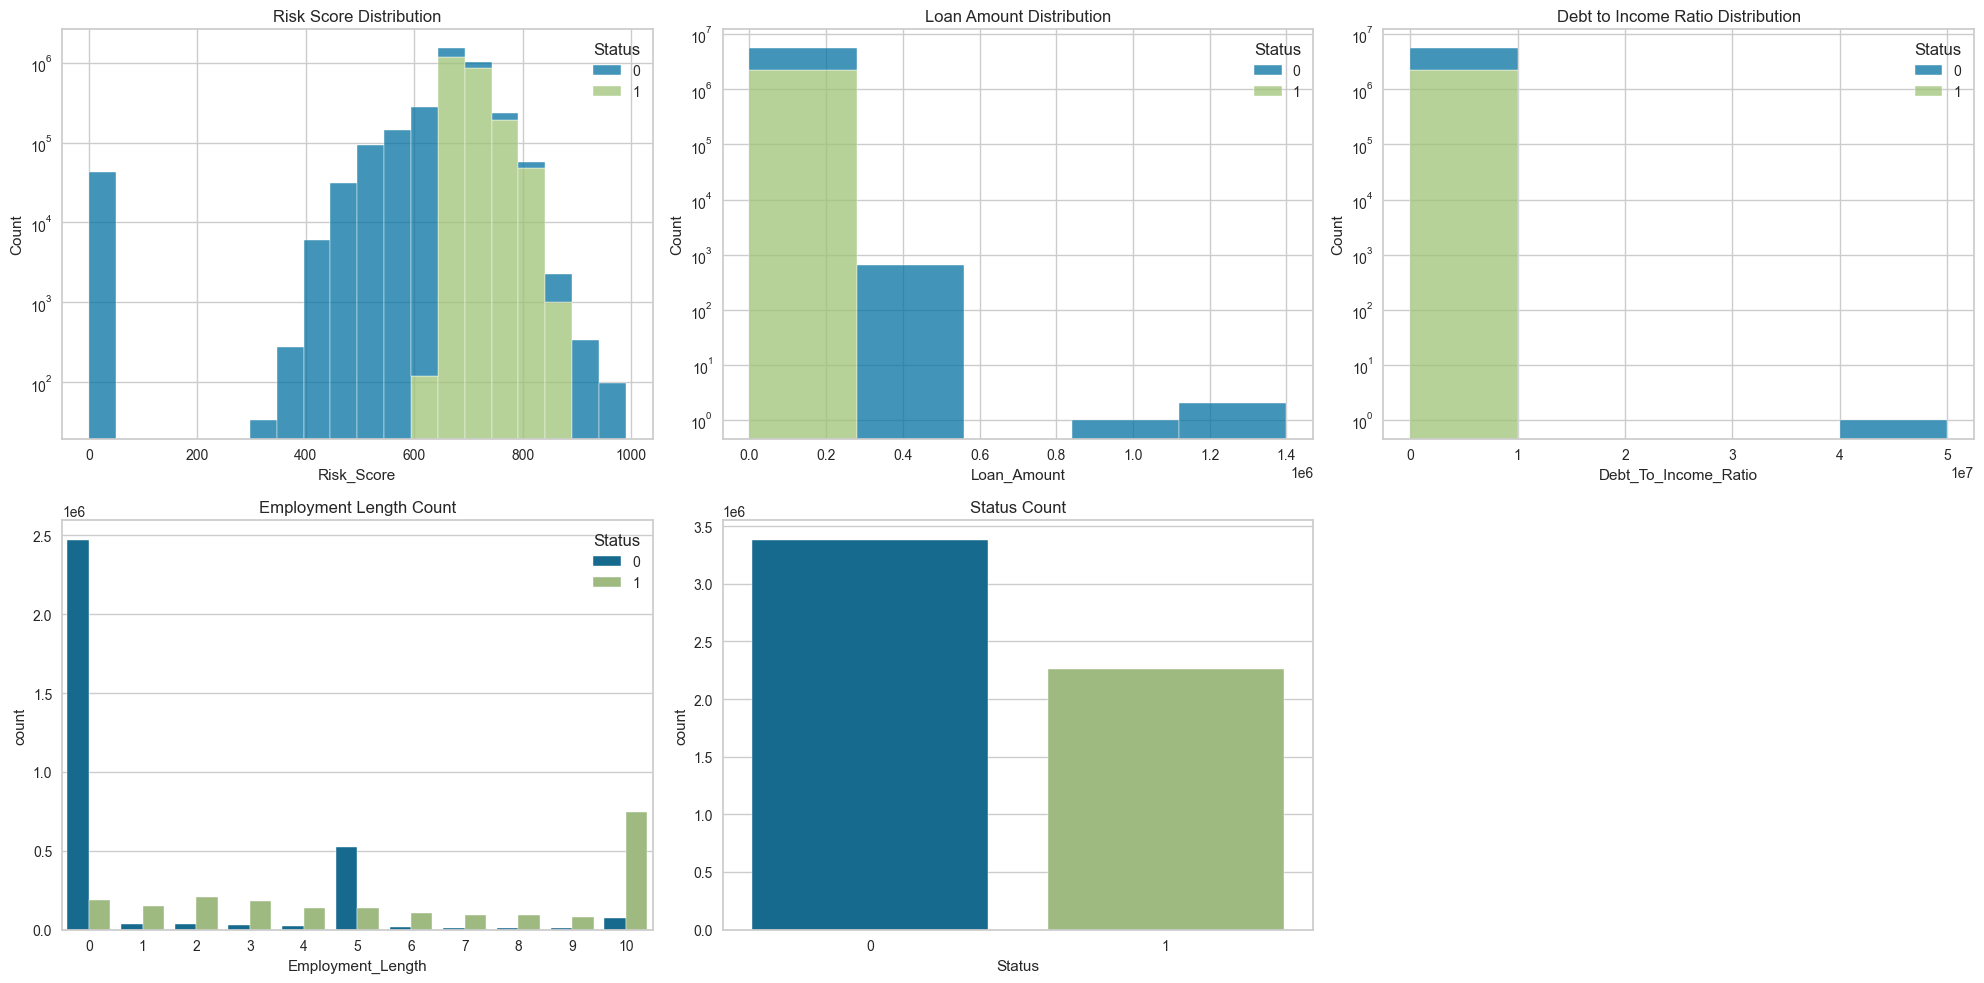

In [102]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(data=df, x='Risk_Score', hue='Status', multiple='stack', bins=20,
             ax=axes[0, 0])
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('Risk Score Distribution')

sns.histplot(data=df, x='Loan_Amount', hue='Status', multiple='stack', bins=5,
             ax=axes[0, 1])
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Loan Amount Distribution')

sns.histplot(data=df, x='Debt_To_Income_Ratio', hue='Status',
             multiple='stack', bins=5, ax=axes[0, 2])
axes[0, 2].set_yscale('log')
axes[0, 2].set_title('Debt to Income Ratio Distribution')

sns.countplot(x=df.dropna(subset=['Employment_Length']).Employment_Length,
              hue=df.Status, ax=axes[1, 0])
axes[1, 0].set_title('Employment Length Count')

sns.countplot(x=df.Status, ax=axes[1, 1])
axes[1, 1].set_title('Status Count')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

The first thing we notice is that the maximums and minimums for accepted and rejected loans are radically different for several features. For example, the risk score range for accepted loans goes from 600 to 900, while it seems to go from 0 to 1000 for rejected ones. 

Credit risk scores determine the probability of a financial loss resulting from a borrower's failure to repay a loan. They are generally calculated on a scale from 300 to 850. A "good" score is often in the range of 670 to 739, while scores of 740 to 799 are considered "very good," and 800 and higher is "excellent,". Therefore, so it is to be expected that risk scores with extreme values are automatically rejected, as they are either not good enough or "too good to be true".

We see the same issue with the loan amount and dti. Loans exceeding a certain amount seem to be discarded, as well as applications where the dti is too high, probably because it would be unrealistic to expect the loan would be fully paid back, or at least the risk would be too high for the lending company. 

In order to get a clearer idea of how our data is distributed, we are going to filter out rejected loans with one or more extreme values. This should highlight any possible relationships between the features and whether a loan is accepted or not.


In [8]:
risk_score_min = df[df.Status == 1].Risk_Score.min()
risk_score_max = df[df.Status == 1].Risk_Score.max()
loan_amount_max = df[df.Status == 1].Loan_Amount.max()
debt_to_income_ratio_max = df[df.Status == 1].Debt_To_Income_Ratio.max()
df_filtered = df[df.Risk_Score >= risk_score_min]
df_filtered = df_filtered[df_filtered.Risk_Score <= risk_score_max]
df_filtered = df_filtered[df_filtered.Loan_Amount <= loan_amount_max]
df_filtered = df_filtered[
    df_filtered.Debt_To_Income_Ratio <= debt_to_income_ratio_max]

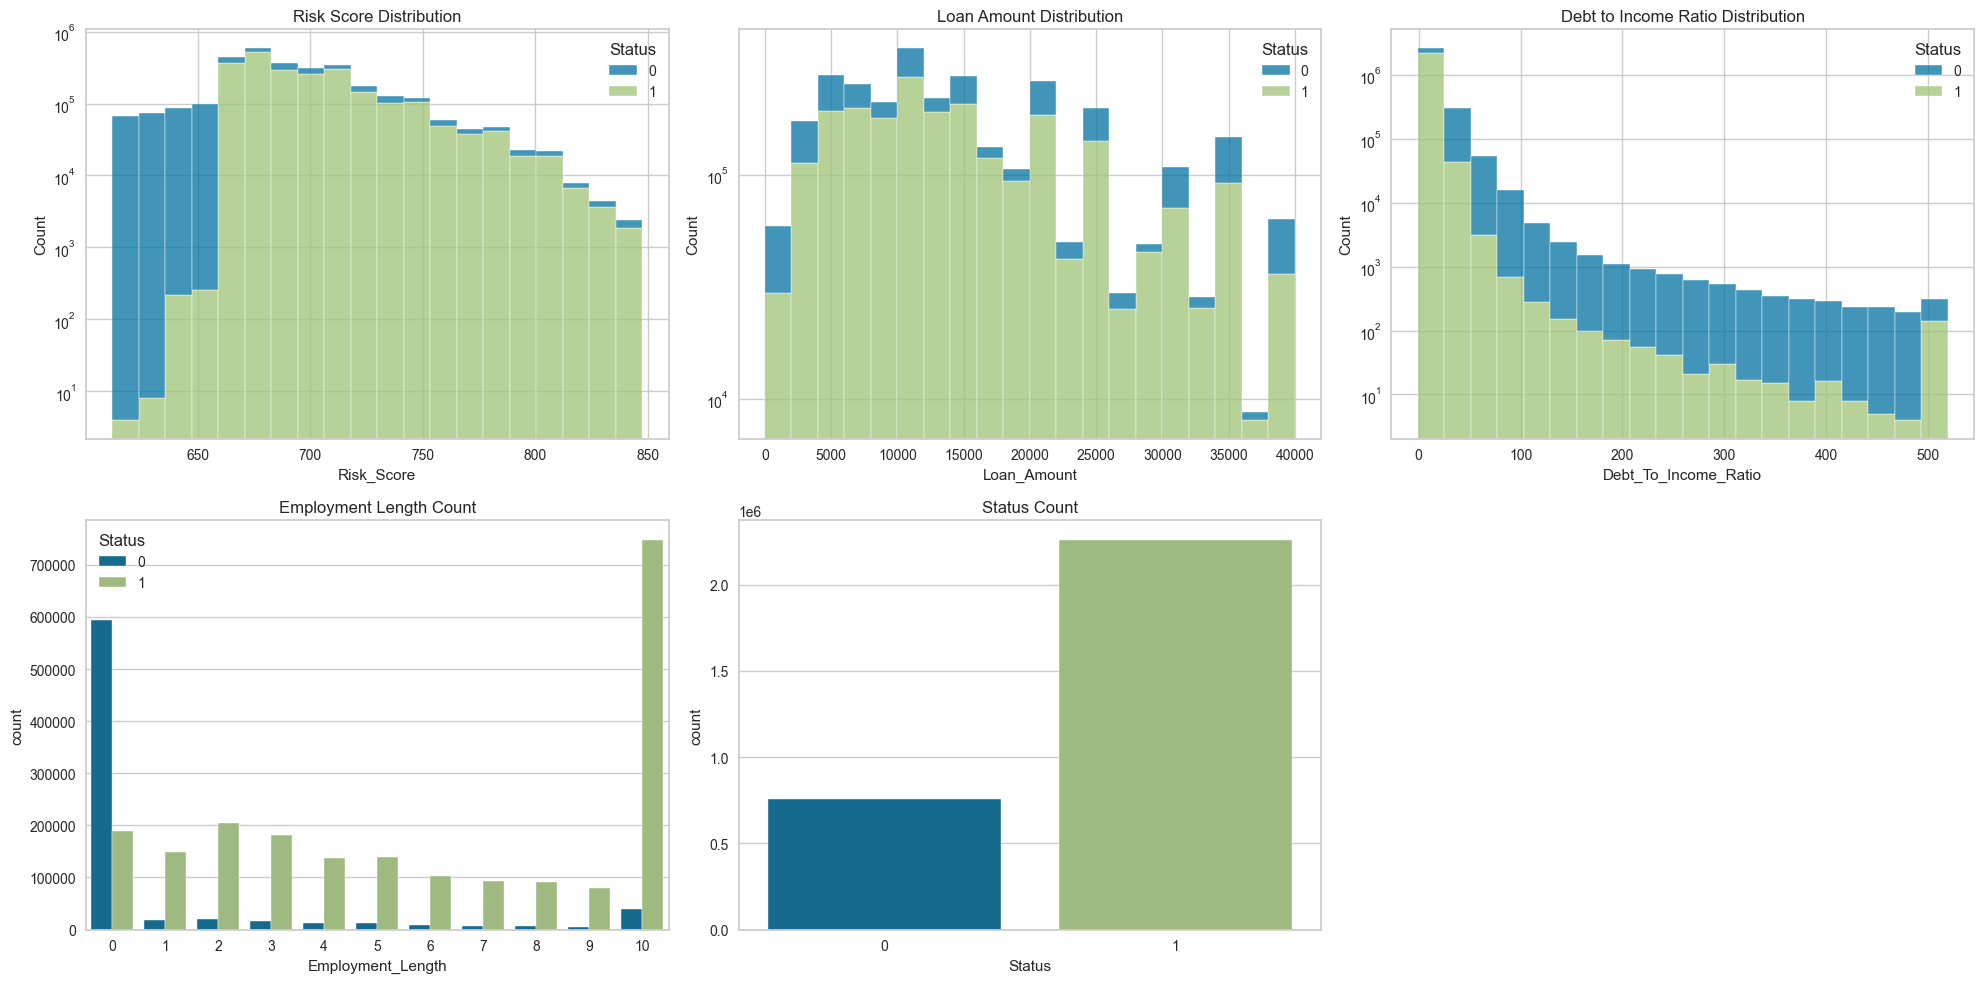

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(data=df_filtered, x='Risk_Score', hue='Status', multiple='stack',
             bins=20,
             ax=axes[0, 0])
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('Risk Score Distribution')

sns.histplot(data=df_filtered, x='Loan_Amount', hue='Status', multiple='stack',
             bins=20,
             ax=axes[0, 1])
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Loan Amount Distribution')

sns.histplot(data=df_filtered, x='Debt_To_Income_Ratio', hue='Status',
             multiple='stack', bins=20, ax=axes[0, 2])
axes[0, 2].set_yscale('log')
axes[0, 2].set_title('Debt to Income Ratio Distribution')

sns.countplot(data=df_filtered.dropna(subset=['Employment_Length']),
              x='Employment_Length', hue='Status', ax=axes[1, 0])
axes[1, 0].set_title('Employment Length Count')

sns.countplot(x=df_filtered.Status, ax=axes[1, 1])
axes[1, 1].set_title('Status Count')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

As we can see, there are a number of differences:
- While most loans in the original database were rejected, now we see that 3 out of 4 loans are approved.
- As for the risk score, we see that most loans with a score lower than 660 are rejected.
- The amount requested does not seem to have a direct impact on the loan outcome.
- The lower the debt to income ratio, the higher the chance of getting a loan approved. However, we notice most loans with a dti over 500 are approved.
- Most applicants have either less than 1 or more than 10 years of work experience. Similarly, the great majority of rejected loans come from people with less than 1 year of experience. It is also worth noting that the amount of rejected applications from people with 5 years of experience has decreased dramatically from over half a million to XXX.

In [91]:
df_filtered.shape

(3018618, 8)

As we can see, the filtered dataset has 2.6M less entries.

Let's see if there is any significant difference when it comes to states and zip codes.

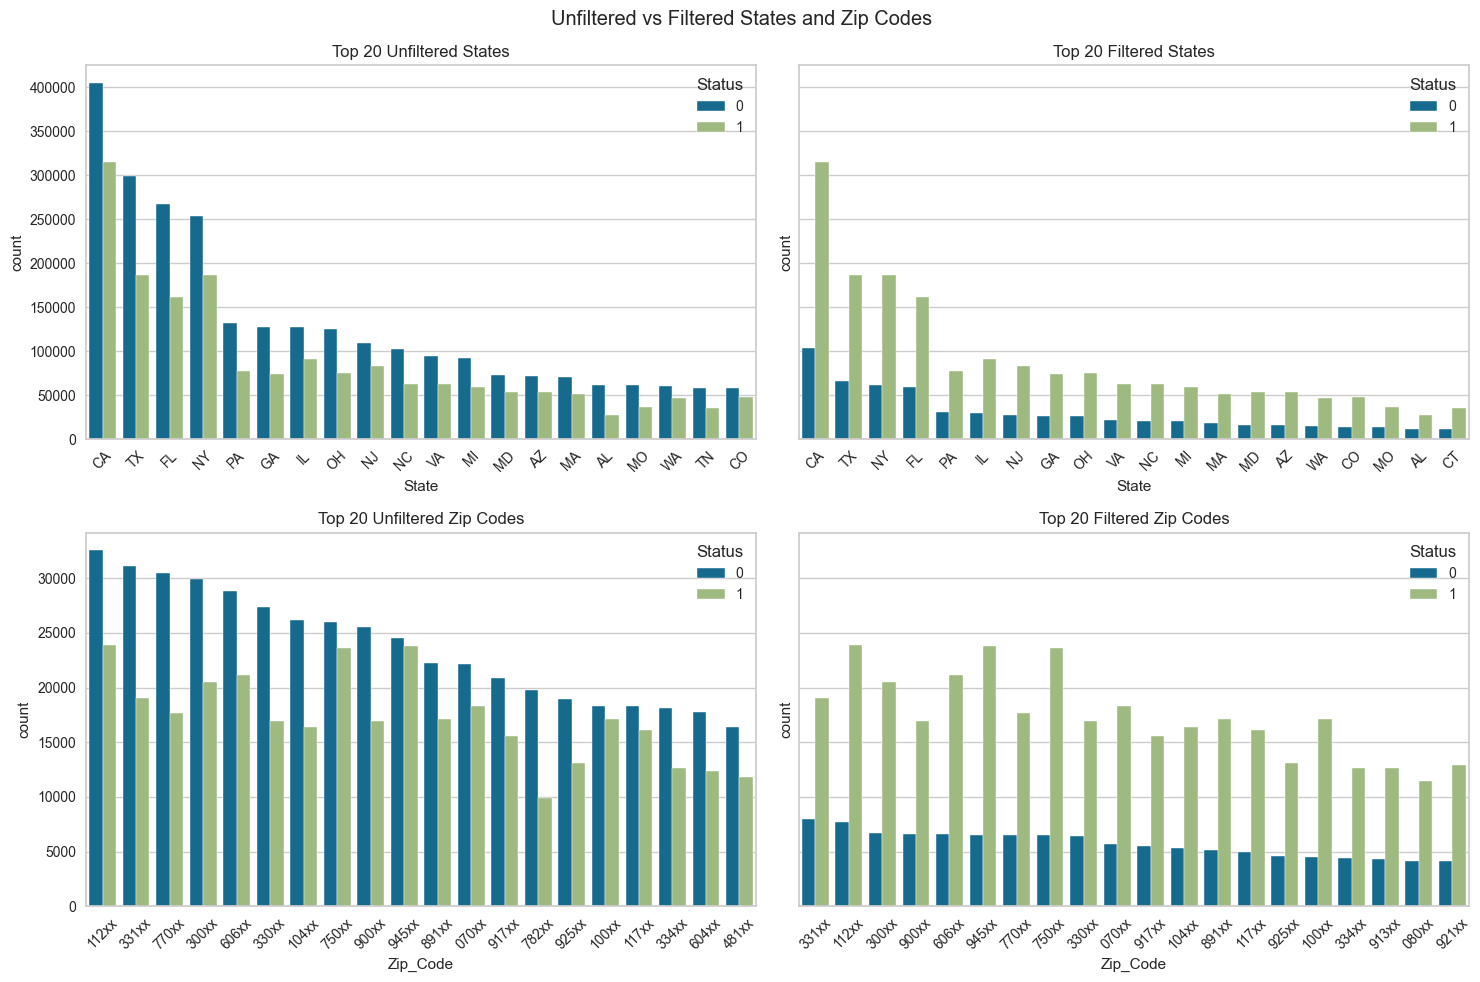

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey='row')
fig.suptitle('Unfiltered vs Filtered States and Zip Codes')

top_twenty_states = df[df['Status'] == 0]['State'].value_counts().head(
    20).index.tolist()
df_top_twenty = df[df['State'].isin(top_twenty_states)]
ax0 = sns.countplot(x='State', data=df_top_twenty, hue='Status',
                    order=top_twenty_states, ax=axes[0, 0])
ax0.tick_params('x', labelrotation=45)
ax0.set_title('Top 20 Unfiltered States')

filtered_top_states = df_filtered[df_filtered['Status'] == 0][
    'State'].value_counts().head(20).index.tolist()
df_filtered_top = df_filtered[df_filtered['State'].isin(filtered_top_states)]
ax1 = sns.countplot(x='State', data=df_filtered_top, hue='Status',
                    order=filtered_top_states, ax=axes[0, 1])
ax1.tick_params('x', labelrotation=45)
ax1.set_title('Top 20 Filtered States')

top_twenty_zip_codes = df[df['Status'] == 0]['Zip_Code'].value_counts().head(
    20).index.tolist()
df_top_twenty = df[df['Zip_Code'].isin(top_twenty_zip_codes)]
ax0 = sns.countplot(x='Zip_Code', data=df_top_twenty, hue='Status',
                    order=top_twenty_zip_codes, ax=axes[1, 0])
ax0.tick_params('x', labelrotation=45)
ax0.set_title('Top 20 Unfiltered Zip Codes')

filtered_top_zip_codes = df_filtered[df_filtered['Status'] == 0][
    'Zip_Code'].value_counts().head(20).index.tolist()
df_filtered_top = df_filtered[
    df_filtered['Zip_Code'].isin(filtered_top_zip_codes)]
ax1 = sns.countplot(x='Zip_Code', data=df_filtered_top, hue='Status',
                    order=filtered_top_zip_codes, ax=axes[1, 1])
ax1.tick_params('x', labelrotation=45)
ax1.set_title('Top 20 Filtered Zip Codes')

plt.tight_layout()

plt.show()


As we can see, although slightly rearranged, the great majority of top states and zip codes for the unfiltered data also remain in the filtered data, which means there is no significant change when removing extreme values.

Now let's take a look at the correlation matrices:

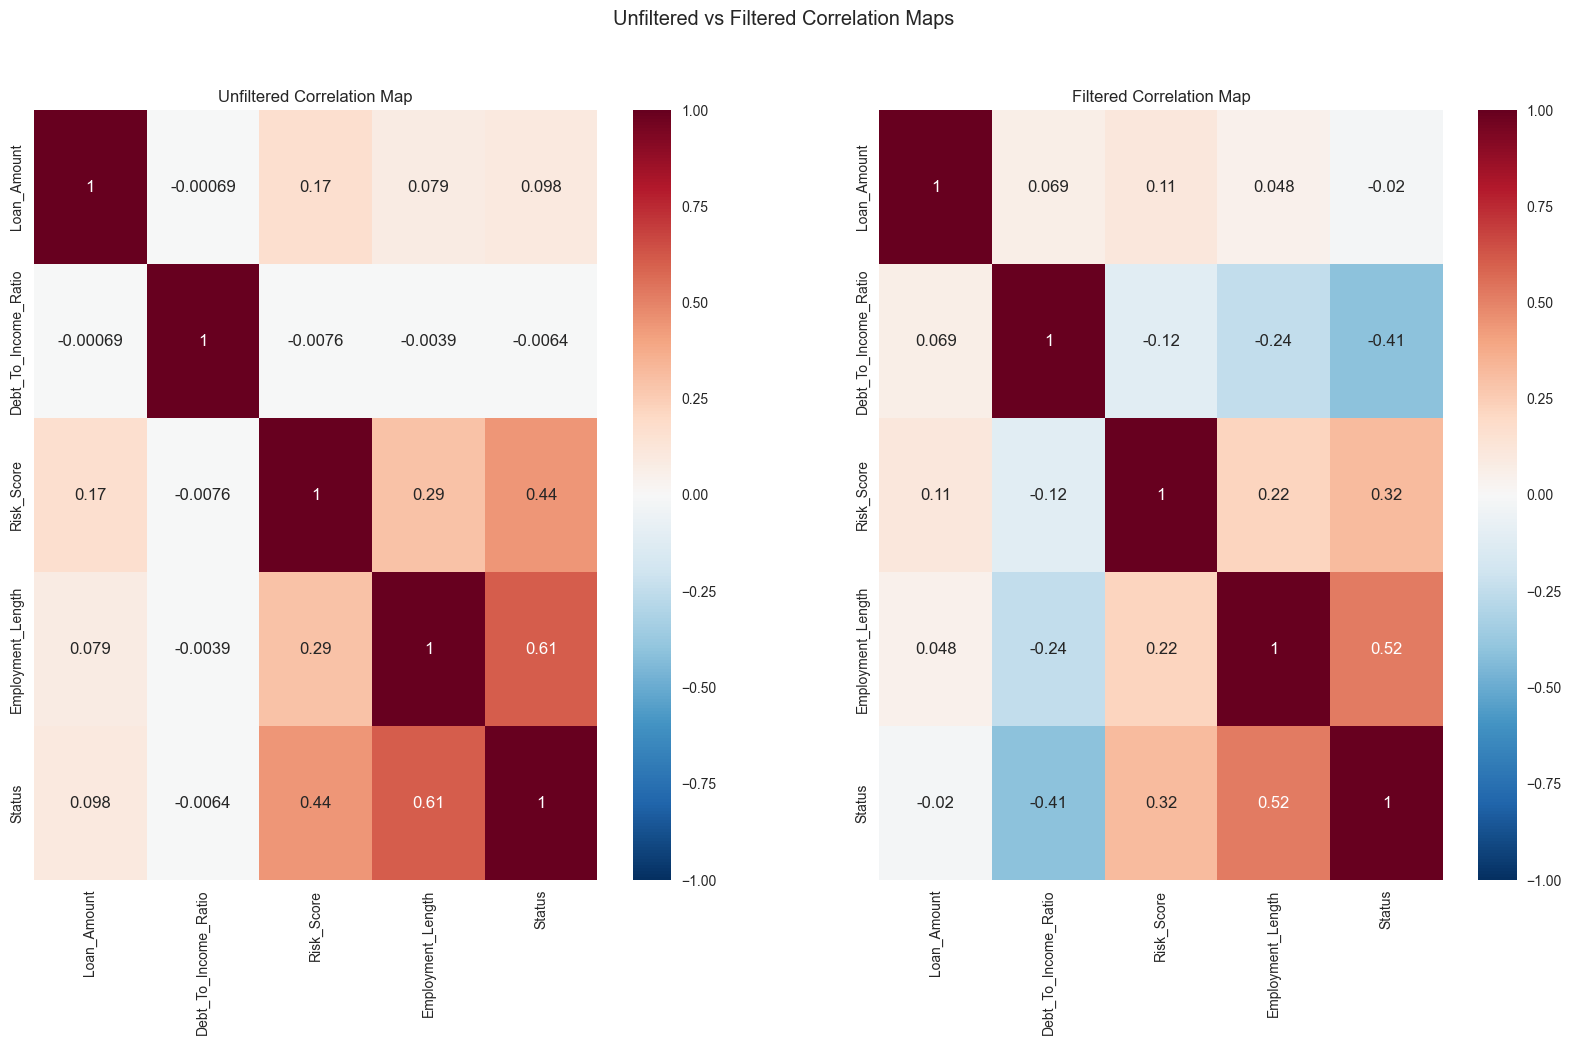

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Unfiltered vs Filtered Correlation Maps')
ax0 = sns.heatmap(
    df.corr(numeric_only=True),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1, ax=axes[0])
ax0.set_title('Unfiltered Correlation Map')
ax1 = sns.heatmap(
    df_filtered.corr(numeric_only=True),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1, ax=axes[1])
ax1.set_title('Filtered Correlation Map')
plt.show()

In both cases, there are no strong correlations (0.7-0.9). However, we can
see moderate correlation (0.5-0.7) between employment length and status.
This corresponds to what we have seen in previous plots: applicants with more
 work experience are more likely to have their loan approved.

We can also see there is one significant difference between both heatmaps. In
 the filtered version, the negative correlation between dti and both
 employment length and status is considerably stronger. Because the
 relationship is not fully linear (there is a high number of accepted loans
 from applicants with a dti over 500), the correlation score is relatively low.

Now that we have analysed our features, let us take a look at their mutual
information scores.

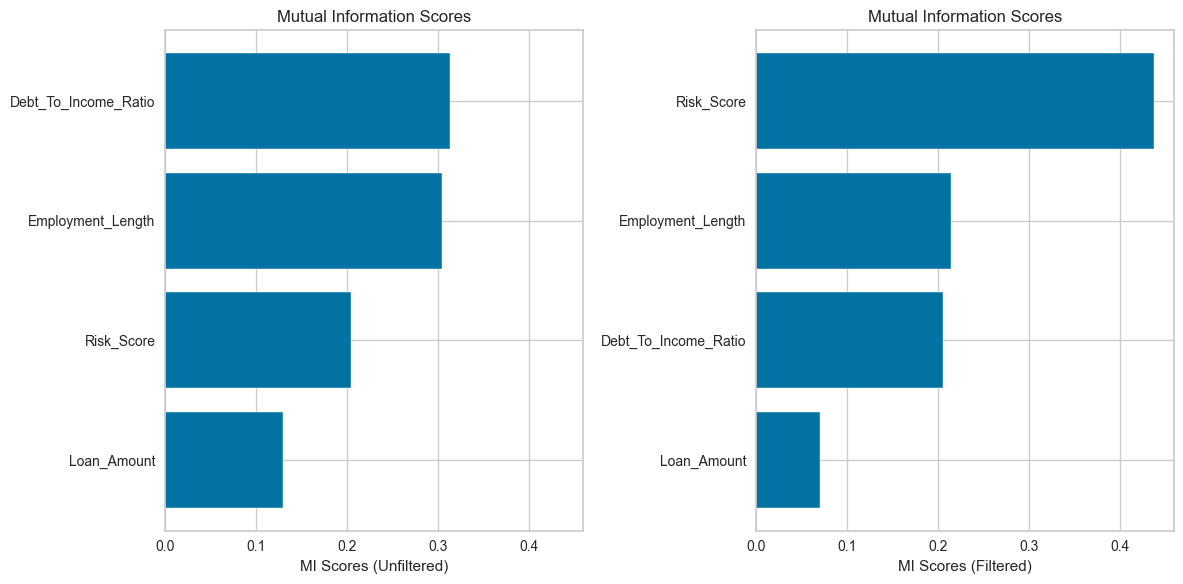

In [75]:
plt.figure(figsize=(12, 6))

sample = df.sample(frac=0.01, random_state=42)
mi_scores_unfiltered = make_mi_scores(
    sample.drop(['Status', 'Loan_Title', 'Zip_Code',
                 'State'], axis=1),
    sample['Status'])

plt.subplot(1, 2, 1)
plot_mi_scores(mi_scores_unfiltered)
plt.xlabel("MI Scores (Unfiltered)")

sample = df_filtered.sample(frac=0.01, random_state=42)
mi_scores_filtered = make_mi_scores(
    sample.drop(['Status', 'Loan_Title', 'Zip_Code',
                 'State'], axis=1),
    sample['Status'])

plt.subplot(1, 2, 2, sharex=plt.gca())
plot_mi_scores(mi_scores_filtered)
plt.xlabel("MI Scores (Filtered)")

plt.tight_layout()
plt.show()


Filtering the data increases the mutual information score for risk score.
However, the score for the other three fields seems to decrease.

### Statistical Analysis

In our statistical analysis, we aim to investigate whether there is a
significant difference between approved and rejected loans across various features. To achieve this, we employed
 statistical tests tailored to the nature of the features: Chi-Square and ANOVA
  for categorical features and z-test for numeric ones.

Chi-Square Test
For a categorical independent variable $x$ and a binary dependent variable $y$ (indicating approved or rejected):

$H_0$: There is no relationship between $x$ and the likelihood of $y$. Chi-square $= 0$
$H_1$: There is a significant relationship between $x$ and the likelihood of $y$. Chi-square $\neq 0$
We applied the Chi-Square test to examine the association between binary
features and the approval of loans. The test evaluates whether the
distribution of approved loans differs significantly based on the categories
 of the examined feature.

z-Test
For numeric features, we utilized the z-test to compare means between approved and rejected loans. The hypotheses are framed as follows:

$H_0$: Rejected loans have an average equal to or higher than approved ones for feature $x$.
$H_1$: Rejected loans have a lower average than approved ones for feature $x$.
This test provides insights into whether there is a significant difference in the means of numeric features between the two groups, shedding light on potential associations between these features and whether a loan is approved.

ANOVA (Analysis of Variance)
For categorical features with more than two levels, we applied the Analysis of Variance (ANOVA) test. ANOVA assesses whether there are statistically significant differences in means across multiple groups. The hypotheses for ANOVA are similar to those of the z-test, testing for differences in average values among categories of the categorical feature. The resulting F-statistic and p-value from ANOVA help determine if there is a significant overall effect of the categorical variable on loan approval.

In [9]:
numeric_features = ['Risk_Score', 'Debt_To_Income_Ratio', 'Loan_Amount',
                    'Employment_Length']


for column in numeric_features:
    perform_ztest(df, column)

categorical_features = ['State', 'Zip_Code']
for column in categorical_features:
    perform_anova(df, column)

Risk_Score: z-statistic: -908.4779003616331, p-value: 0.0, confidence interval 95%: (-88.58224587833267, -88.07009787166733)
Debt_To_Income_Ratio: z-statistic: 15.182464455002664, p-value: 1.0, confidence interval 95%: (256.92194405809954, 317.5604693884142)
Loan_Amount: z-statistic: -234.632138651246, p-value: 0.0, confidence interval 95%: (-2307.511340076021, -2271.5159897122676)
Employment_Length: z-statistic: -1772.3873834235605, p-value: 0.0, confidence interval 95%: (-4.704515486302442, -4.693189955774247)
State: F-statistic: nan, p-value: nan, confidence interval: (0, 1)
Zip_Code: F-statistic: nan, p-value: nan, confidence interval: (0, 1)


For the unfiltered dataset, we reject the null hypothesis for risk score, loan
amount, employment length, state and zip code. On the other hand, for debt to
income ratio, we see there is no evidence whatsoever to reject it.

In [10]:
for column in numeric_features:
    perform_ztest(df_filtered, column)

for column in categorical_features:
    perform_anova(df_filtered, column)

Risk_Score: z-statistic: -586.6024866209589, p-value: 0.0, confidence interval 95%: (-27.40453547328291, -27.20252019077959)
Debt_To_Income_Ratio: z-statistic: 774.1020176016242, p-value: 1.0, confidence interval 95%: (18.410986004638822, 18.561497092492907)
Loan_Amount: z-statistic: 35.01456387854037, p-value: 1.0, confidence interval 95%: (420.91243253864747, 475.471758946398)
Employment_Length: z-statistic: -1026.2160171862993, p-value: 0.0, confidence interval 95%: (-4.825216362333488, -4.809415124881855)
State: F-statistic: nan, p-value: nan, confidence interval: (0, 1)
Zip_Code: F-statistic: nan, p-value: nan, confidence interval: (0, 1)


As we can see, once we filter the dataset, the p-value for loan amount goes
all the way from 0 to 1. In other words, any evidence that the loan amount is
 lower for rejected loans disappears. This could mean that, in general, the
 rejected loans we filtered out had a lower loan amount.

## Statistical modelling

As we previously described, we would like to predict which loans are accepted and rejected. To accomplish this task, we need a
classification model that can tell accepted loans (1) from rejected ones (0). we are going to split our model in two subsets: train and test.

### Data Split

In [3]:
X = df.drop(['Status', 'State', 'Zip_Code', 'Loan_Title'],
            axis=1)
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    stratify=y,
                                                    random_state=42)

In [10]:
print(f'Number of Samples (and positive features) by set: \n - Train: '
      f'{len(X_train)} ('
      f'{y_train.value_counts().get(1)}) '
      f' \n'
      f' - Test: {len(X_test)}'
      f' ({y_test.value_counts().get(1)})')

Number of Samples (and positive features) by set: 
 - Train: 3949079 (1582302)  
 - Test: 1692463 (678130)


In order to automate our pipeline process, we are going to use PyCaret.
PyCaret is a low-code machine learning library designed to automate
the end-to-end machine learning workflow. Some key features include automated
 machine learning, preprocessing, and model interpretability.

The first thing we need to do is setup a session.

In [4]:
s = setup(pd.concat([X_train, y_train], axis=1), target='Status',
          session_id=123)

,Description,Value
0,Session id,123
1,Target,Status
2,Target type,Binary
3,Original data shape,"(3949079, 5)"
4,Transformed data shape,"(3949079, 5)"
5,Transformed train set shape,"(2764355, 5)"
6,Transformed test set shape,"(1184724, 5)"
7,Numeric features,4
8,Rows with missing values,42.3%
9,Preprocess,True


It automatically detects the target type and does any necessary data
preprocessing before training the models.

Now, we are going to compare all the models PyCaret offers. It will
automatically choose the best performing one according to the chosen metric.

In [43]:
best_F1_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9883,0.9981,0.9942,0.9771,0.9855,0.9757,0.9758,11.8960
et,Extra Trees Classifier,0.9821,0.9951,0.9819,0.9737,0.9778,0.9628,0.9628,106.0920
dt,Decision Tree Classifier,0.9817,0.9811,0.9764,0.9779,0.9771,0.9619,0.9619,6.9520
rf,Random Forest Classifier,0.9793,0.9966,0.9824,0.9665,0.9744,0.9571,0.9572,172.9460
xgboost,Extreme Gradient Boosting,0.9775,0.9958,0.9865,0.9585,0.9723,0.9533,0.9536,13.3000
gbc,Gradient Boosting Classifier,0.9736,0.9950,0.9872,0.9490,0.9677,0.9454,0.9459,767.2630
knn,K Neighbors Classifier,0.9690,0.9875,0.9798,0.9449,0.9621,0.9359,0.9364,26.1490
ada,Ada Boost Classifier,0.9663,0.9924,0.9822,0.9369,0.9590,0.9305,0.9312,42.4040
lr,Logistic Regression,0.8433,0.9308,0.7812,0.8193,0.7998,0.6711,0.6716,9.5170
svm,SVM - Linear Kernel,0.7369,0.0000,0.5975,0.7288,0.5850,0.4243,0.4523,83.2890


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

The best performing model was Light Gradient Boosting Machine for our chosen
metric, F1. Although we already have a very high score, we are going to try
to improve it even further by tuning its hyperparameters.

In [46]:
best_tuned_model = tune_model(best_F1_model, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9895,0.9983,0.9950,0.9792,0.9870,0.9783,0.9783
1,0.9897,0.9984,0.9950,0.9795,0.9872,0.9786,0.9786
2,0.9902,0.9984,0.9953,0.9804,0.9878,0.9796,0.9796
3,0.9895,0.9984,0.9949,0.9793,0.9870,0.9783,0.9783
4,0.9897,0.9984,0.9953,0.9794,0.9873,0.9787,0.9788
5,0.9901,0.9985,0.9952,0.9803,0.9877,0.9794,0.9795
6,0.9896,0.9983,0.9949,0.9794,0.9871,0.9784,0.9785
7,0.9897,0.9983,0.9950,0.9796,0.9872,0.9786,0.9787
8,0.9898,0.9984,0.9953,0.9795,0.9873,0.9787,0.9788


Fitting 10 folds for each of 10 candidates, totalling 100 fits


LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=260, n_jobs=-1, num_leaves=70, objective=None,
               random_state=123, reg_alpha=2, reg_lambda=3, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

We managed to improve it by 0.0018. Although it may not be a significant
improvement, we will still keep the tuned model.

With method evaluate_model, we can gain some valuable insights regarding our
model's performance.

In [48]:
evaluate_model(best_tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

Now that we are happy with our model, we can finalise it and use it with our
test data. finalize_model trains a given estimator on the entire dataset
including the holdout set.

In [51]:
best_tuned_model_finalized = finalize_model(best_tuned_model)

In [52]:
pred_unseen = predict_model(best_tuned_model_finalized,
                            pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9823,0.9934,0.9955,0.9811,0.9882,0.9521,0.9526


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


As we can see, our model works almost identically with unseen data. We can
save it and deploy it for production. Let us move on to the next step.

In [53]:
save_model(best_tuned_model_finalized,
           'accpeted-rejected/model_accepted_rejected_finalized')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Loan_Amount',
                                              'Debt_To_Income_Ratio',
                                              'Risk_Score',
                                              'Employment_Length'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWr...
                                 boosting